In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import os
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from numpy import mean,std
import seaborn as sns
from sklearn.model_selection import cross_val_score
import sklearn.metrics
from xgboost import plot_tree
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error

In [2]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [3]:
os.chdir('C:\\Users\\scott\\DAEN_690\\CALC_NLP_v3')

In [4]:
conn = sqlite3.connect('calc.db')

In [5]:
c = conn.cursor()

## Data Prep

In [6]:
def findOutlier(list_name): 
    s1 = [list_name[i][12] for i in range(len(list_name))]
    data_mean = mean(s1)
    data_std = std(s1)
    cut_off = data_std * 3
    lower = data_mean - cut_off 
    upper = data_mean + cut_off    
    df4 = pd.DataFrame(list_name, columns=['row','contract_number','business_size','schedule','site','begin_date','end_date','SIN','vendor_name','labor_category','education','years_experience','first_year_price','second_year_price','third_year_price','pdf_url','job_description1','zip','score_initial','allwyn_job_initial','score','allwyn_job'])
    df4 = df4.drop(df4[(df4.first_year_price > upper) | (df4.first_year_price < lower)].index)
    return df4

In [7]:
s1 = c.execute("SELECT * FROM calc_final WHERE jd_matching_allwyn = 'IT Project Manager I';").fetchall()
s2 = c.execute("SELECT * FROM calc_final WHERE jd_matching_allwyn = 'IT Project Manager III';").fetchall()
s3 = c.execute("SELECT * FROM calc_final WHERE jd_matching_allwyn = 'Senior Computer Security Systems Specialist';").fetchall()
s4 = c.execute("SELECT * FROM calc_final WHERE jd_matching_allwyn = 'Senior Security Analyst';").fetchall()
s5 = c.execute("SELECT * FROM calc_final WHERE jd_matching_allwyn = 'Cloud Engineer';").fetchall()
s6 = c.execute("SELECT * FROM calc_final WHERE jd_matching_allwyn = 'Senior Data Scientist';").fetchall()
s7 = c.execute("SELECT * FROM calc_final WHERE jd_matching_allwyn = 'User Experience (UX) Developer';").fetchall()
s8 = c.execute("SELECT * FROM calc_final WHERE jd_matching_allwyn = 'Software Developer I';").fetchall()
s9 = c.execute("SELECT * FROM calc_final WHERE jd_matching_allwyn = 'Test Automation Engineer ';").fetchall()
s10 = c.execute("SELECT * FROM calc_final WHERE jd_matching_allwyn = 'Senior Java Developer';").fetchall()
s11 = c.execute("SELECT * FROM calc_final WHERE jd_matching_allwyn = 'Software Developer III';").fetchall()

In [8]:
d1 = findOutlier(s1)
d2 = findOutlier(s2)
d3 = findOutlier(s3)
d4 = findOutlier(s4)
d5 = findOutlier(s5)
d6 = findOutlier(s6)
d7 = findOutlier(s7)
d8 = findOutlier(s8)
d9 = findOutlier(s9)
d10 = findOutlier(s10)
d11 = findOutlier(s11)

df4 = pd.concat([d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11])

In [9]:
c.execute("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;")
print(c.fetchall())

[('allwyn',), ('c_temp',), ('calc',), ('calc_final',), ('predictive_modeling_tbl',)]


In [10]:
allwyn = c.execute("""SELECT * FROM calc_final""").fetchall()

In [11]:
df = pd.DataFrame(allwyn)

In [12]:
df.columns = ['row','contract_number','business_size','schedule','site','begin_date','end_date','SIN','vendor_name','labor_category','education','years_experience','first_year_price','second_year_price','third_year_price','pdf_url','job_description1','zip','score_initial','allwyn_job_initial','score','allwyn_job']

In [13]:
df4['year'] = df4['begin_date'].str.slice(start = -2)

In [14]:
df4['year'] = pd.to_numeric(df4['year'])

In [15]:
df5 = df4.loc[df4['year'] > 15]

In [17]:
# changed from 250 to 200
df2 = df.loc[df['first_year_price'] < 200]

In [16]:
df6 = df4.loc[df4['year'] > 16]

In [18]:
df3 = df2.loc[df2['score'] > .4]

In [19]:
X = df4[['allwyn_job','years_experience','education']]
y = df4['first_year_price']

In [20]:
X = pd.get_dummies(X)

In [21]:
X = X.drop(['allwyn_job_User Experience (UX) Developer'], axis=1)

In [22]:
X = X.drop(['education_Ph.D.'], axis=1)

In [23]:
print(y.max(),
y.min(),
y.max() - y.min())

286.2 21.11 265.09


In [24]:
# seed 9 is best
np.random.seed(9)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)

## Multiple Linear Regression

In [25]:
lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)

print('Intercept: ', lm.intercept_)
print('Coefficients: ', lm.coef_)

Intercept:  117.67202032652135
Coefficients:  [  4.9915062   -5.88004023  10.34288495   4.61792287  -2.71301177
  -4.85815173  -3.40862619  -5.64421491  -5.45024204   2.86423816
   0.77409096 -36.08927538 -14.54609011]


In [26]:
coefficients = lm.coef_
x_variables = X.columns

In [27]:
coefficient_dict = {x_variables[i]: coefficients[i] for i in range(len(x_variables))}

In [28]:
print('Intercept: ', round(lm.intercept_,2))
for k,v in coefficient_dict.items():
    print(k,":",round(v,2))

Intercept:  117.67
years_experience : 4.99
allwyn_job_Cloud Engineer : -5.88
allwyn_job_IT Project Manager I : 10.34
allwyn_job_IT Project Manager III : 4.62
allwyn_job_Senior Computer Security Systems Specialist : -2.71
allwyn_job_Senior Data Scientist : -4.86
allwyn_job_Senior Java Developer : -3.41
allwyn_job_Senior Security Analyst : -5.64
allwyn_job_Software Developer I : -5.45
allwyn_job_Software Developer III : 2.86
allwyn_job_Test Automation Engineer  : 0.77
education_Bachelors : -36.09
education_Masters : -14.55


In [29]:
print('RMSE: ', round(np.sqrt(np.mean((lm.predict(X_test) - y_test)**2)),2), '$/hr')
errors = abs(lm.predict(X_test) - y_test)
print('MAE', round(np.mean(errors),2), '$/hr')
mape = 100 * (errors / y_test)

accuracy = 100 - np.mean(mape)
print('accuracy: ', round(accuracy, 2), '%')
print('R-squared: ', round(lm.score(X_test, y_test),3))

RMSE:  36.57 $/hr
MAE 28.46 $/hr
accuracy:  72.08 %
R-squared:  0.343


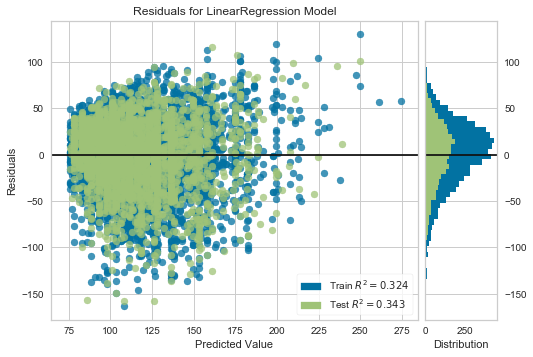

C:\Users\scott\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ResidualsPlot(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000018ECFFD7388>,
              estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                         n_jobs=None, normalize=False),
              hist=True, is_fitted='auto', line_color=None, qqplot=False,
              test_alpha=None, test_color=None, train_alpha=None,
              train_color=None)

In [30]:
residuals_plot(lm, X_train, y_train, X_test, y_test)

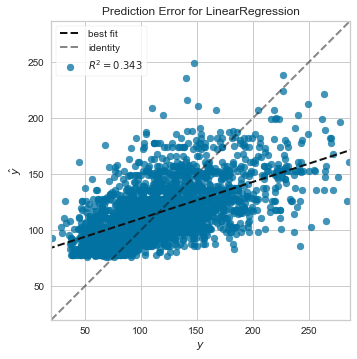

PredictionError(alpha=0.75,
                ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000018ED0B8C308>,
                bestfit=True,
                estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                           n_jobs=None, normalize=False),
                identity=True, is_fitted='auto', shared_limits=True)

In [31]:
prediction_error(lm, X_train, y_train, X_test, y_test)

In [32]:
y_train.describe().T

count    6015.000000
mean      115.610879
std        44.844427
min        26.310000
25%        82.025000
50%       108.740000
75%       142.815000
max       285.210000
Name: first_year_price, dtype: float64

In [33]:
lmpredictions = lm.predict(X_test)

lmpredictions.max()

249.4624900914004

In [34]:
lmpredictions.min()

75.93853004282832

## Random Forest

In [35]:
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

In [36]:
regressor.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [37]:
Y_pred = regressor.predict(X_test)

In [38]:
errors = abs(Y_pred - y_test)
print('RMSE: ', round(np.sqrt(np.mean((regressor.predict(X_test)- y_test)**2)),2), ' $/hr')
print('mean absolute error: ', round(np.mean(errors),2), ' $/hr')
mape = 100 * (errors / y_test)

accuracy = 100 - np.mean(mape)
print('accuracy: ', round(accuracy, 2), '%')

RMSE:  36.72  $/hr
mean absolute error:  28.3  $/hr
accuracy:  72.49 %


In [39]:
# importances = list(regressor.feature_importances_)

In [40]:
# plt.style.use('fivethirtyeight')
# x_values = list(range(len(importances)))

# plt.bar(x_values, importances, orientation = 'vertical')
# plt.xticks(x_values, X, rotation = 'vertical')
# plt.ylabel('Importance');plt.xlabel('Variable');plt.title('Variable Importances')

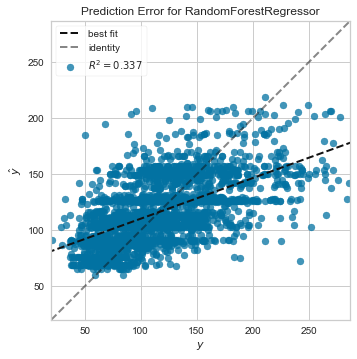

PredictionError(alpha=0.75,
                ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000018ED0E67D48>,
                bestfit=True,
                estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                                criterion='mse', max_depth=None,
                                                max_features='auto',
                                                max_leaf_nodes=None,
                                                max_samples=None,
                                                min_impurity_decrease=0.0,
                                                min_impurity_split=None,
                                                min_samples_leaf=1,
                                                min_samples_split=2,
                                                min_weight_fraction_leaf=0.0,
                                                n_estimators=100, n_jobs=None,
                                               

In [41]:
prediction_error(regressor, X_train, y_train, X_test, y_test)

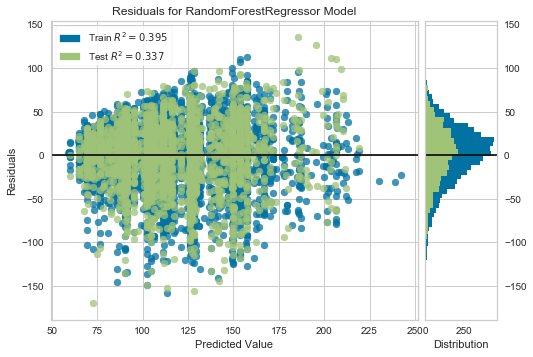

C:\Users\scott\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ResidualsPlot(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000018ED0EBBC48>,
              estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                              criterion='mse', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=0,
                                              verb

In [42]:
residuals_plot(regressor, X_train, y_train, X_test, y_test)

## XG Boost

In [43]:
#lambda 9000 gamma 100
xgbregressor = xgb.XGBRegressor(n_estimators=100, max_depth=3)

In [44]:
xgbregressor.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [46]:
y_pred = xgbregressor.predict(X_test)

C:\Users\scott\anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [47]:
errors = abs(y_pred - y_test)
print('RMSE: ', round(np.sqrt(mean_squared_error(y_test,y_pred)),2), ' $/hr')
print('mean absolute error: ', round(np.mean(errors),2), ' $/hr')
mape = 100 * (errors / y_test)

accuracy = 100 - np.mean(mape)
print('accuracy: ', round(accuracy, 2), '%')

RMSE:  36.21  $/hr
mean absolute error:  28.04  $/hr
accuracy:  72.66 %


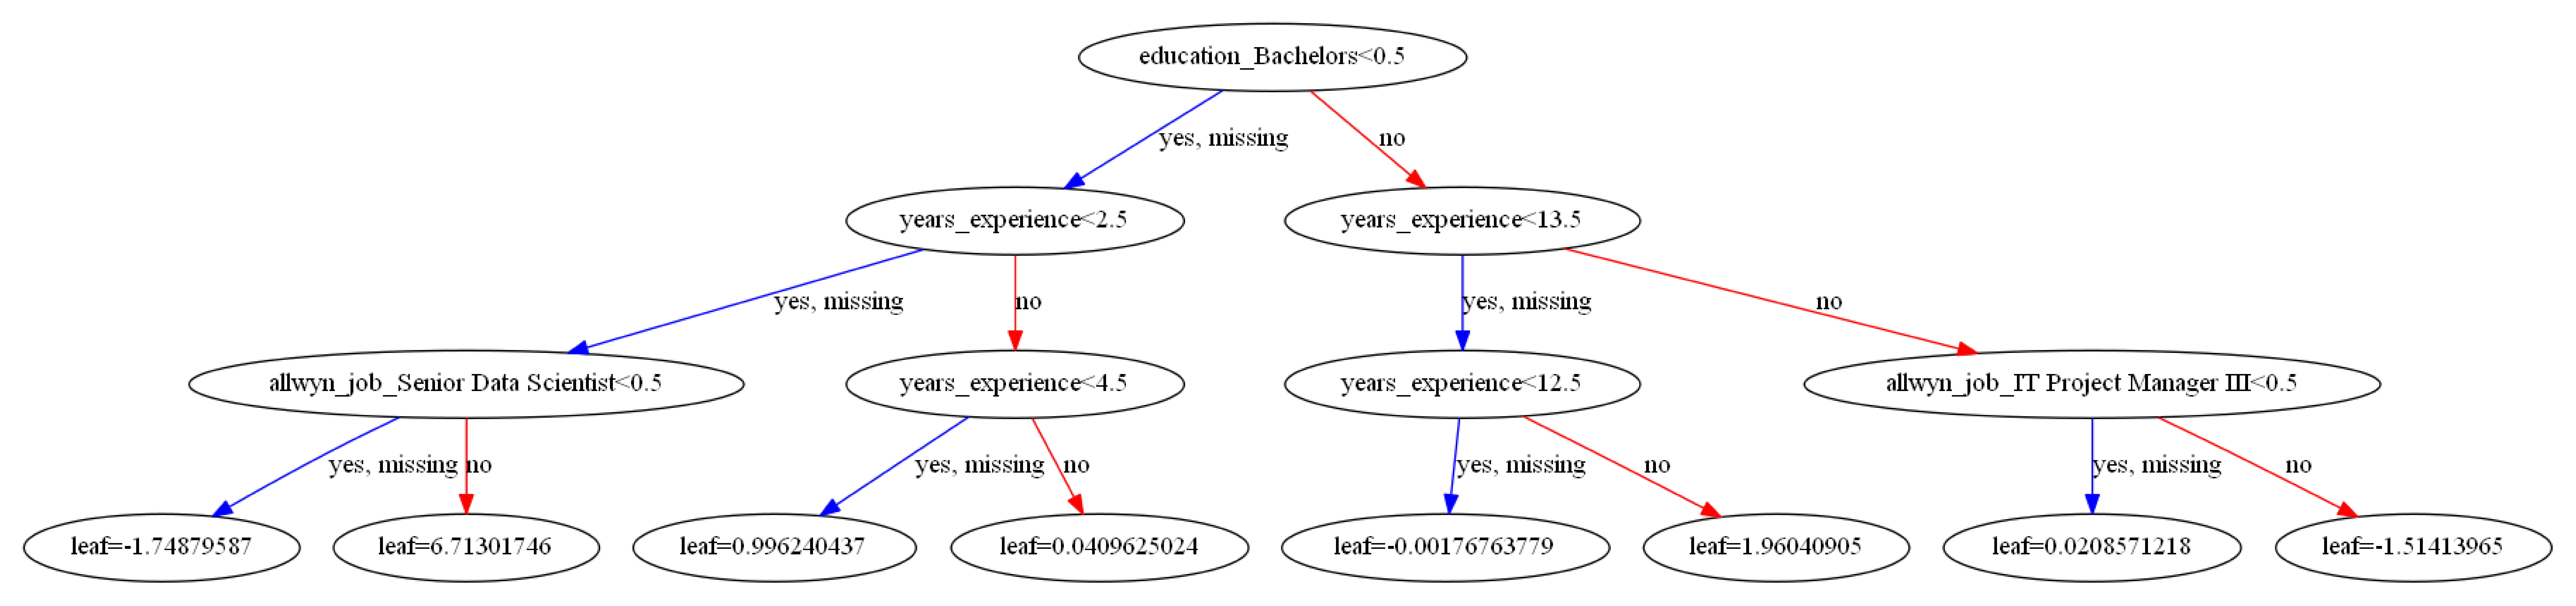

In [49]:
plot_tree(xgbregressor, num_trees = 99)
fig = plt.gcf() # gcf: get current figure
fig.set_figheight(20)
fig.set_figwidth(20)
fig.set_dpi(800)

C:\Users\scott\anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\Users\scott\anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


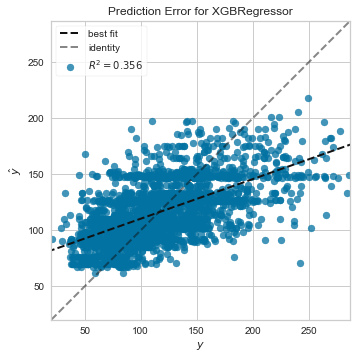

PredictionError(alpha=0.75,
                ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000018ED2094148>,
                bestfit=True,
                estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                       colsample_bylevel=1, colsample_bynode=1,
                                       colsample_bytree=1, gamma=0, gpu_id=-1,
                                       importance_type='gain',
                                       interaction_constraints='',
                                       learning_rate=0.300000012,
                                       max_delta_step=0, max_depth=3,
                                       min_child_weight=1, missing=nan,
                                       monotone_constraints='()',
                                       n_estimators=100, n_jobs=12,
                                       num_parallel_tree=1,
                                       objective='reg:squarederror',
                    

In [50]:
prediction_error(xgbregressor, X_train, y_train, X_test, y_test)

C:\Users\scott\anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\Users\scott\anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\Users\scott\anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


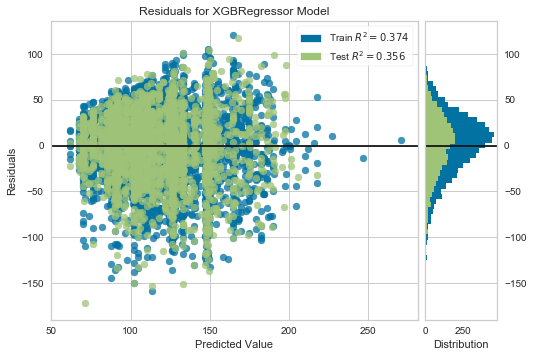

C:\Users\scott\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ResidualsPlot(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000018ED25AE808>,
              estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=3,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=12,
                                     num_parallel_tree=1,
                                     objective='reg:squarederror',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                        

In [51]:
residuals_plot(xgbregressor, X_train, y_train, X_test, y_test)

In [89]:
y.describe().T

count    8593.000000
mean      116.075785
std        44.929676
min        21.110000
25%        82.530000
50%       109.520000
75%       143.420000
max       286.200000
Name: first_year_price, dtype: float64

In [90]:
max(y_pred)

219.67995

In [91]:
max(y_train)

285.21

## Misc. Work

In [41]:
allwyn_job_list = ['IT Project Manager I', 'IT Project Manager III', 'Cloud Engineer', 'Senior Computer Security Systems Specialist', 'Senior Security Analyst', 'User Experience (UX) Developer', 'Software Developer I', 'Test Automation Engineer ', 'Software Developer III']

In [42]:
# for job in allwyn_job_list:
#     job1 = df.loc[df['allwyn_job'] == job].sort_values(by=['score'], ascending = False)
#     job1 = job1[['allwyn_job','labor_category','score','1st_year_price']]
#     display(job1.head(5))

## BLS

### Data Prep

In [53]:
bls = pd.read_csv('C:\\Users\\scott\\DAEN_690\\Final2.csv')

In [54]:
bls2 = pd.read_csv(r'C:\Users\scott\DAEN_690\BLS_NLP_Extract_2016_2020.txt', 
                 sep = '|',encoding='unicode_escape', dtype='unicode',
                 index_col=False)

In [55]:
X2 = bls[['AllwynTitle','Years_Exp','Education']]
y2 = bls[['Hourly_Rate']]

In [56]:
X2 = pd.get_dummies(X2)

In [57]:
X2 = X2.drop(['AllwynTitle_User Experience (UX) Developer'], axis=1)

In [58]:
X2 = X2.drop(['Education_Doctorate'], axis=1)

In [59]:
y3 = y2['Hourly_Rate'].values

In [60]:
y4 = pd.Series(y3)

In [61]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y4,test_size = 0.2)

## Multiple Linear Regression (BLS)

In [62]:
lm2 = linear_model.LinearRegression()
lm2.fit(X2_train, y2_train)

print('Intercept: ', lm2.intercept_)
print('Coefficients: ', lm2.coef_)


Intercept:  12.905649529607434
Coefficients:  [ 2.16657469 10.50534716  2.61523189  2.61726013  5.7524669  13.58174884
 15.66042997  5.76240856 15.69104954 15.6820159  -3.8845992  -6.12778355
 -1.34071667]


In [63]:
print('RMSE: ', np.sqrt(np.mean((lm2.predict(X2_test) - y2_test)**2)), '$/hr')
errors2 = abs(lm2.predict(X2_test) - y2_test)
print('MAE', round(np.mean(errors2),2), '$/hr')
mape2 = 100 * (errors2 / y2_test)

accuracy2 = 100 - np.mean(mape2)
print('accuracy: ', round(accuracy2, 2), '%')
print('R-squared: ', lm2.score(X2_test, y2_test))

RMSE:  10.497340724965705 $/hr
MAE 7.85 $/hr
accuracy:  77.07 %
R-squared:  0.6236945072204112


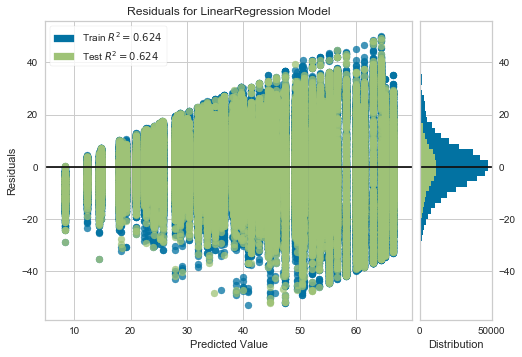

C:\Users\scott\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ResidualsPlot(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001C07E657808>,
              estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                         n_jobs=None, normalize=False),
              hist=True, is_fitted='auto', line_color=None, qqplot=False,
              test_alpha=None, test_color=None, train_alpha=None,
              train_color=None)

In [66]:
residuals_plot(lm2, X2_train, y2_train, X2_test, y2_test)

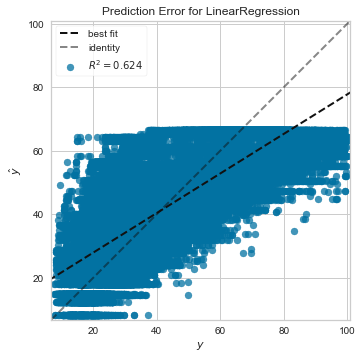

PredictionError(alpha=0.75,
                ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001C06AFEFC48>,
                bestfit=True,
                estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                           n_jobs=None, normalize=False),
                identity=True, is_fitted='auto', shared_limits=True)

In [67]:
prediction_error(lm2, X2_train, y2_train, X2_test, y2_test)

## Random Forest (BLS)

In [68]:
regressor2 = RandomForestRegressor(n_estimators = 100, random_state = 0)

In [69]:
regressor2.fit(X2_train,y2_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [70]:
Y2_pred = regressor2.predict(X2_test)

In [71]:
y2_test

270742    28.95
1378      37.29
100697    57.59
246493    19.49
604532    80.43
          ...  
617857    31.91
309022    34.21
218042    28.94
437579    18.58
166900    51.76
Length: 126360, dtype: float64

In [72]:
# y3_test = y2_test['Hourly_Rate'].values
y3_test = y2_test

In [73]:
errors2 = abs(Y2_pred - y3_test)
print('RMSE: ', round(np.sqrt(np.mean((regressor2.predict(X2_test)- y3_test)**2)),2), ' $/hr')
print('mean absolute error: ', round(np.mean(errors2),2), ' $/hr')
mape2 = 100 * (errors2 / y3_test)

accuracy2 = 100 - np.mean(mape2)
print('accuracy: ', round(accuracy2, 2), '%')


RMSE:  10.08  $/hr
mean absolute error:  7.48  $/hr
accuracy:  78.39 %


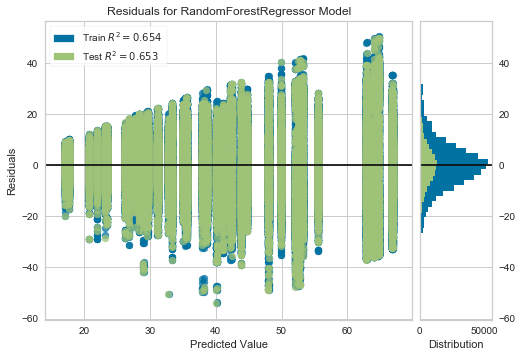

C:\Users\scott\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ResidualsPlot(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001C06B0D4848>,
              estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                              criterion='mse', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=0,
                                              verb

In [74]:
residuals_plot(regressor2, X2_train, y2_train, X2_test, y2_test)

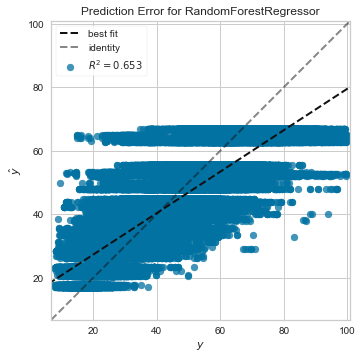

PredictionError(alpha=0.75,
                ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001C05DAC5C88>,
                bestfit=True,
                estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                                criterion='mse', max_depth=None,
                                                max_features='auto',
                                                max_leaf_nodes=None,
                                                max_samples=None,
                                                min_impurity_decrease=0.0,
                                                min_impurity_split=None,
                                                min_samples_leaf=1,
                                                min_samples_split=2,
                                                min_weight_fraction_leaf=0.0,
                                                n_estimators=100, n_jobs=None,
                                               

In [75]:
prediction_error(regressor2, X2_train, y2_train, X2_test, y2_test)

## XG Boost (BLS)

In [76]:
xgbregressor2 = xgb.XGBRegressor()

In [77]:
xgbregressor2.fit(X2_train, y2_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [78]:
y22_pred = xgbregressor2.predict(X2_test)

C:\Users\scott\anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [80]:
errors2 = abs(y22_pred - y2_test)
print('RMSE: ', np.sqrt(mean_squared_error(y2_test,y22_pred)))
print('mean absolute error: ', round(np.mean(errors2),2), ' $/hr')
mape2 = 100 * (errors2 / y2_test)

accuracy2 = 100 - np.mean(mape2)
print('accuracy: ', round(accuracy2, 2), '%')

RMSE:  10.080410237676587
mean absolute error:  7.48  $/hr
accuracy:  78.38 %


C:\Users\scott\anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\Users\scott\anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\Users\scott\anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


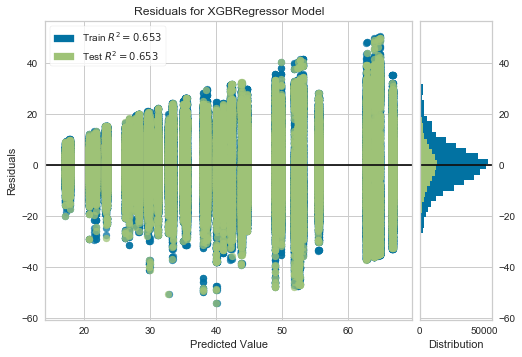

C:\Users\scott\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ResidualsPlot(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001C05E7EEF08>,
              estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=12,
                                     num_parallel_tree=1,
                                     objective='reg:squarederror',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                        

In [81]:
residuals_plot(xgbregressor2, X2_train, y2_train, X2_test, y2_test)

C:\Users\scott\anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


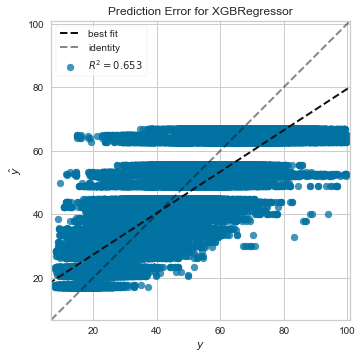

PredictionError(alpha=0.75,
                ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001C0638F8048>,
                bestfit=True,
                estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                       colsample_bylevel=1, colsample_bynode=1,
                                       colsample_bytree=1, gamma=0, gpu_id=-1,
                                       importance_type='gain',
                                       interaction_constraints='',
                                       learning_rate=0.300000012,
                                       max_delta_step=0, max_depth=6,
                                       min_child_weight=1, missing=nan,
                                       monotone_constraints='()',
                                       n_estimators=100, n_jobs=12,
                                       num_parallel_tree=1,
                                       objective='reg:squarederror',
                    

In [82]:
prediction_error(xgbregressor2, X2_train, y2_train, X2_test, y2_test)

In [66]:
conn.close()